# Logistic regression with pystan

In this notebook, we will apply logistic regression to the Palmer Penguins dataset using pystan.

## 0. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import arviz as az
import stan

In [2]:
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

## 1. Data Exploration

Firstly we load the data:

In [3]:
penguins = pd.read_csv("penguins.csv")
penguins.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


There are 3 reprented species of pinguins: Adelie, Gentoo and Chinstrap. The species variable will be our dependent variable.

<BarContainer object of 3 artists>

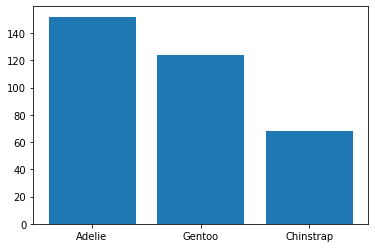

In [4]:
species_counts = dict(penguins['species'].value_counts())
plt.bar(species_counts.keys(), species_counts.values())

We are going to consider four variables as independent variables: 
- `bill_length_mm`
- `bill_depth_mm`
- `flipper_length_mm`
- `body_mass_g`

In [5]:
penguins = penguins.copy()[['species',
                        'bill_length_mm',
                        'bill_depth_mm',
                        'flipper_length_mm',
                        'body_mass_g']]
                        
penguins.dropna(inplace=True)
penguins.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0


An easy and intuitive way of taking a first glance to our data is by doing a `seaborn` scatter matrix:

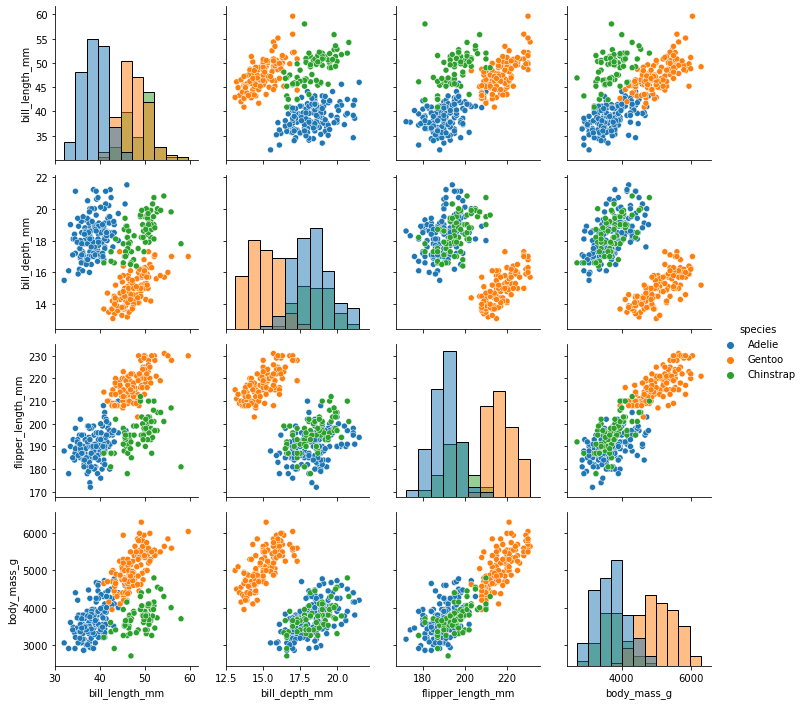

In [6]:
g = sns.PairGrid(penguins, hue="species")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## 1. Binary univariate classification

Again, we start by the most simple case, a two-class classification. We will just consider species `Adelie` and `Chinstrap`, i.e., $y \in \{0,1\}$. Again, here we will employ just independent variable, `flipper_length_mm`, i.e., $x \in \mathbb R$.

In [7]:
species = ['Adelie', 'Chinstrap']

p1 = penguins[penguins['species'].isin(species)]
y_0 = ((p1['species'] == species[0])*1).values
N=len(y_0)
ind_vars = 'flipper_length_mm'
x_0 = p1[ind_vars].values.reshape((N, 1))

We can observe the distribution of our two 1-dimensional clusters with a violin plot:

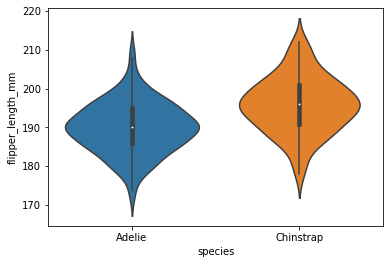

In [8]:
sns.violinplot(data=p1[['species','flipper_length_mm']], x='species', y='flipper_length_mm')
plt.show()

Now that we have the data, we need to specify the model, that is, our prior distribution and likelihood. As the likelihood, we will chose a Bernoulli $(p= \theta )$ distribution, and for the priors we select $N(\mu=0, \sigma=10)$ for both $\alpha$ and $\beta$.

We define the stan model

In [9]:
code = """                                                                                         
data {                                                                                               
  int N; //the number observations                                                                                                                 
  int K; //the number of features                                                                    
  int y[N]; //the response                                                                           
  matrix[N,K] X; //the model matrix  
}                                                                                                    
parameters {                                                                                         
  real alpha;                                                                                        
  vector[K] beta; //the regression parameters                                                        
}                                                                                                    
transformed parameters {                                                                             
  vector[N] linpred;                                                                                 
  linpred = alpha+X*beta; 
  #vector[N] bd;
  #bd = -alpha/beta;
}                                                                                                    
model {                                                                                              
  alpha ~ normal(0,10); //prior for the intercept following Gelman 2008                              
                                                                                                   
  for(i in 1:K)                                                                                      
    beta[i] ~ normal(0,10);                                                                 
                                                                                                   
  y ~ bernoulli_logit(linpred);                                                                      
}                                                                                                                                                                                                       
"""  

... and the data for such model

In [10]:
data = {                                                                                             
    'N': N,                                                                                        
    'K': 1,                                                                                        
    'y': y_0,                                                                                     
    'X': x_0                                                                                             
}  

Compile:

In [11]:
posterior = stan.build(code, data=data, random_seed=1)



Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 15, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 16, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be do

Obtain a sample from the posterior

In [12]:
fit = posterior.sample(num_chains=4, num_samples=2000)



Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   3% (302/12000)
Sampling:   4% (501/12000)
Sampling:   5% (600/12000)
Sampling:   7% (800/12000)
Sampling:   8% (1000/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1500/12000)
Sampling:  15% (1800/12000)
Sampling:  18% (2200/12000)
Sampling:  22% (2600/12000)
Sampling:  24% (2900/12000)
Sampling:  44% (5300/12000)
Sampling:  62% (7500/12000)
Sampling:  80% (9600/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 7.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000126 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.5e-05 se

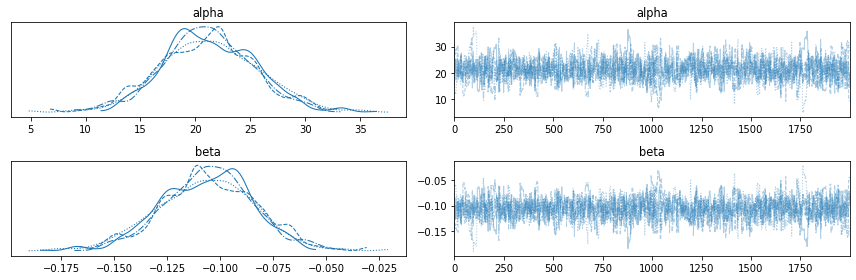

In [13]:
varnames = ['alpha', 'beta']
az.plot_trace(fit, varnames)
plt.tight_layout()
plt.show()

### 2. Binary multivariate

In this case, we increment the number of independent variables to 2. So, we are going to classifie Adelie and Chinstrap penguins according to their bill depth and flipper length.

In [14]:
species = ['Adelie', 'Chinstrap']

p1 = penguins[penguins['species'].isin(species)]
y = ((p1['species'] == species[0])*1).values
ind_vars = ['bill_depth_mm', 'flipper_length_mm']
x = p1[ind_vars].values

In [15]:
N = len(y)

In [16]:
x.shape, y.shape

((219, 2), (219,))

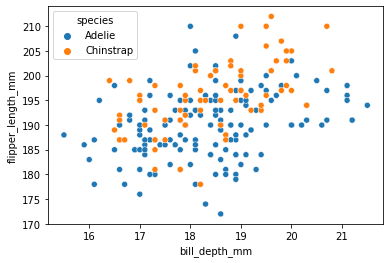

In [17]:
sns.scatterplot(data=p1, x="bill_depth_mm", y="flipper_length_mm", hue="species")
plt.show()

In [18]:
data = {                                                                                             
    'N': N,                                                                                        
    'K': 2,                                                                                        
    'y': y,                                                                                     
    'X': x                                                                                             
}  

In [19]:
posterior = stan.build(code, data=data, random_seed=1)



Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 15, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 16, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be do

In [20]:
fit = posterior.sample(num_chains=4, num_samples=1000)



Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (302/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  42% (3400/8000)
Sampling:  44% (3500/8000)
Sampling:  46% (3700/8000)
Sampling:  61% (4900/8000)
Sampling:  75% (6000/8000)
Sampling:  89% (7100/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sa

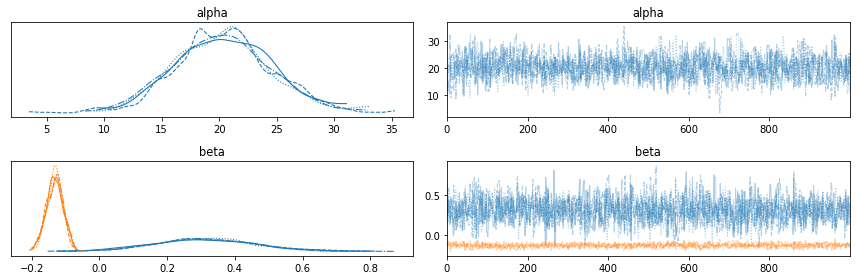

In [21]:
varnames = ['alpha', 'beta']
az.plot_trace(fit, varnames)
plt.tight_layout()
plt.show()

## 2. Multinomial logistic regression

Finally, for the dependent variable we are going to use the three classes (Adelie, Gentoo and Chinstrap), and the four considered dependent variables. We are also going to standardize the data, since this will help the sampler to run more efficiently:

In [22]:
y_s = pd.Categorical(penguins['species']).codes
N = len(y_s)
x_n = penguins.columns[1:]
x_s = penguins[x_n].values
x_s = (x_s - x_s.mean(axis=0))/x_s.std(axis=0)

In [23]:
(y_s.shape, x_s.shape)

((342,), (342, 4))

In [24]:
M = len(np.unique(y_s)) #number of classess
K = x_s.shape[1]

Now, we specify the stan code. The main modifications are the dimensions of the parameters $\alpha$ and $\beta$.

In [25]:
code = """                                                                                         
data {                                                                                               
  int N; //the number observations  
  int M; //the number classes
  int K; //the number of features                                                                    
  int y[N]; //the response                                                                           
  matrix[N,K] X; //the model matrix                                                                  
}                                                                                                    
parameters {                                                                                         
  vector[M] alpha;                                                                                    
  vector[M] beta0;
  vector[M] beta1;
  vector[M] beta2;
  vector[M] beta3;
  
}                                                                                                    
transformed parameters {  
  matrix[N,M] linpred;
  
  for (i in 1:N){
    row_vector[M] row;
    row = (alpha+X[i,1]*beta0+X[i,2]*beta1+X[i,3]*beta2+X[i,4]*beta3)';
    linpred[i] = row;    
  }
}
model { 
  alpha ~ normal(0,10);
  beta0 ~ normal(0,10);
  beta1 ~ normal(0,10);
  beta2 ~ normal(0,10);
  beta3 ~ normal(0,10);
  
  for (i in 1:N)
    y[i] ~ categorical(softmax(to_vector(linpred[i])));
    //y[i] ~ categorical_logit(alpha+X[i,1]*beta0+X[i,2]*beta1+X[i,3]*beta2+X[i,4]*beta3);
    //y[i] ~ categorical_logit(to_vector(linpred[i]));
  
}                                                                                                                                                                                                       
"""  

In [26]:
M, N, K, y_s.shape, x_s.shape

(3, 342, 4, (342,), (342, 4))

In [27]:
data = {                                                                                             
    'N': N, 
    'M': M,
    'K': K,                                                                                        
    'y': y_s,                                                                                     
    'X': x_s                                                                                             
}  

In [28]:
posterior = stan.build(code, data=data, random_seed=1)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_ouqrp0cm/model_gvfwioed.stan', line 6, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


The model builds okay so we see that the dimensionalities of the matrix and vectors is consistent. However, when we try to sample from the posterior we get this misterious "Initialization failed.". We have spent many hours trying different approaches to solve this problem but PyStan makes the debugging process complicated, as we cannot add breakpoints see what is exactly the line that causes the RuntimeError.

In [29]:
fit = posterior.sample(num_chains=2, num_samples=1000)

Sampling:   0%
Sampling: Initialization failed.


RuntimeError: Initialization failed.

In [ ]:
#varnames = ['alpha', 'beta']
#az.plot_trace(fit, varnames)
az.plot_trace(fit)
plt.tight_layout()
plt.show()

In [ ]:
?posterior.sample